## Take Home Exercise

### Step 1. Loading data

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

%matplotlib inline

import datetime
import seaborn
import copy
import sys
import os

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing 
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

In [141]:
data = pd.read_csv('../creditScore/Data Scientist.docx')
data.head()

,member_id,loan_amnt,int_rate,issue_d,loan_status,fico_range_low,fico_range_high,annual_inc,last_pymnt_d
0,35784929,18000,9.17%,Oct 2014,Fully Paid,700,704,150000,Oct 2015
1,35914827,14000,11.67%,Oct 2014,Current,670,674,135000,Oct 2015
2,35985086,8400,9.17%,Oct 2014,Current,665,669,75000,Oct 2015
3,35945193,10000,7.69%,Oct 2014,Current,730,734,94000,Oct 2015
4,35754571,2000,12.99%,Oct 2014,Current,680,684,150000,Oct 2015


In [142]:
print 'Original data size:', data.shape
print 'New data size without last_pymnt_d = NA:', data.dropna().shape

data = data[~data['last_pymnt_d'].isnull()]
data['last_pymnt_d'] = data['last_pymnt_d'].apply(lambda x: datetime.datetime.strptime(x, '%b %Y'))
data['issue_d'] = data['issue_d'].apply(lambda x: datetime.datetime.strptime(x, '%b %Y'))
data['int_rate'] = data['int_rate'].apply(lambda x:float(x.strip('%')) / 100.0)

Original data size: (239046, 9)
New data size without last_pymnt_d = NA: (237709, 9)


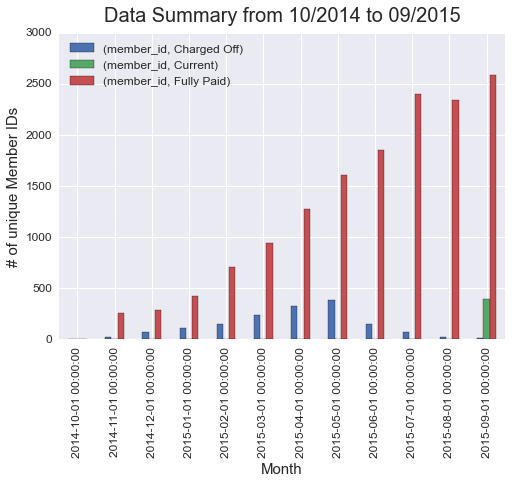

In [6]:
ax = data[data['last_pymnt_d']<datetime.datetime(2015,10,1)].\
groupby(['last_pymnt_d', 'loan_status']).\
agg({'member_id':lambda x:x.nunique()}).\
unstack('loan_status').\
plot(kind='bar')

plt.title('Data Summary from 10/2014 to 09/2015', fontsize=20, y=1.02)
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('# of unique Member IDs',fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.show()

### Step 2. Exploratory Investigation
 
Meassure the Pearson correlations between features and visualize the time series patterns

In [143]:
np.corrcoef(data['int_rate'], data['fico_range_high'])

array([[ 1.       , -0.4250423],
       [-0.4250423,  1.       ]])

In [144]:
np.corrcoef(data['int_rate'], data['fico_range_low'])

array([[ 1.        , -0.42504557],
       [-0.42504557,  1.        ]])

* Since most of the "fico_range_high" and "fico_range_low" are different by 4 points, I used "fico_range_high" to represent each borrower's FICO score.

In [145]:
data['fico_diff'] = data['fico_range_high'] - data['fico_range_low']
data[~data['last_pymnt_d'].isnull()].groupby(['loan_status']).agg({'fico_diff':'mean', 'member_id':'count'})

,fico_diff,member_id
loan_status,,
Charged Off,4.000000,1591
Current,4.000127,219634
Fully Paid,4.000182,16484


### 2. Feature Engineering and Importance

Time relevant features are treated as:

1. Frequency, for example, day of month, day of week, hour of day and etc.
2. Categorical variables

Using Random Forest Classifier to qantify the feature importances, which means loan_amnt and int_rate are weakly negatively correlated. However, if using loan_amnt / annual_inc indicate the capability of paying the loans, they are weakly positively correlated **(with coefficient = 0.14)**.

In [146]:
data.columns

Index([u'member_id', u'loan_amnt', u'int_rate', u'issue_d', u'loan_status',
       u'fico_range_low', u'fico_range_high', u'annual_inc', u'last_pymnt_d',
       u'fico_diff'],
      dtype='object')

In [147]:
tmp = data[data['loan_status']!='Current'].copy()
tmp.ix[tmp['loan_status']=='Current', 'target']=-1
tmp.ix[tmp['loan_status']=='Charged Off', 'target']=0
tmp.ix[tmp['loan_status']=='Fully Paid', 'target']=1

In [148]:
allFeatures = [u'loan_amnt', u'int_rate',
               u'fico_range_high', u'annual_inc', 
               u'last_pymnt_d']

numericFeatures = [u'loan_amnt', u'int_rate',
                   u'fico_range_high', u'annual_inc']

In [180]:
 def data_preprocessing(_data_, scale_=None, target_col='target', timestamp='Date'):
        if allFeatures:
            x_ = _data_[allFeatures].copy()
        else:
            x_ = _data_.copy()

        # any numeric transformation should be entered here
        '''
        x_['reporters_app'] = np.log(x_['reporters_app'])
        x_['reporters_all'] = np.log(x_['reporters_all'])
        x_['reporters_app_movingAvg'] = np.log(x_['reporters_app_movingAvg'])
        x_['moving_avg_dl'] = np.log(x_['moving_avg_dl']+1.0) / x_['reporters_app']
        x_['total_downloads'] = np.log(x_['total_downloads']+100.0) / x_['reporters_app']
        '''
        
        if target_col:
            y_ = _data_[target_col]
            scaler_ = preprocessing.StandardScaler().fit(x_[numericFeatures])
        else:
            y_ = None
            assert scaler_ is not None, ValueError('scaler has not been calucated!')
        
        # Simple treatment of datetime
        if timestamp in x_.columns:
            x_['month'] = x_[timestamp].dt.month.apply(str)
            x_['year'] = x_[timestamp].dt.year.apply(str)
            x_['hour'] = x_[timestamp].dt.hour.apply(str)
            x_['weekday'] = x_[timestamp].dt.dayofweek
            
        # Count frequency and add back
            if 0:
                x_['month_freq'] = x_.groupby(['month'])['month'].transform('count')
                x_['year_freq'] = x_.groupby(['year'])['year'].transform('count')
                x_['hour_freq'] = x_.groupby(['hour'])['hour'].transform('count')
                x_['weekday_freq'] = x_.groupby(['weekday'])['weekday'].transform('count')

                x_.drop([timestamp, 'month', 'year', 'hour', 'weekday'], axis=1, inplace=True)
                tmpFeatures = copy.copy(numericFeatures)
                tmpFeatures.append(['month_freq','year_freq','hour_freq','weekday_freq',])
            else:
                x_.drop([timestamp], axis=1, inplace=True)
            
        try:
            x_[tmpFeatures] = scaler_.transform(x_[tmpFeatures]) 
        except:
            ValueError('The feature scaler does not exist!')

        # dummy coding
        x_ = pd.get_dummies(x_)
        if target_col:    
            processedFeatures = x_.columns

        return x_, y_, processedFeatures

In [181]:
def variable_importance(_model_, x_, y_, fnames, model_name='Random Forest', col='r', TOP_N=50):

    _model_.fit(x_, y_)

    if model_name == 'Random Forest':
        importances = _model_.feature_importances_
        std = np.std([tree.feature_importances_ for tree in _model_.estimators_],
                     axis=0)
    elif model_name == 'Linear Regression':
        importances = np.abs(_model_.coef_)
        std = np.array([0.0] * importances.shape[0])
    else:
        raise ValueError('The model is beyond the current support model list for variable importance!')
    
    indices_ = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(TOP_N):
        print("%d. feature %d -- %s (%f)" % (f + 1, indices_[f], fnames[indices_[f]], 
                                             importances[indices_[f]]))

    # Plot the feature importances of the forest
    fig, ax = plt.subplots(figsize=(15, 10))

    plt.title("{} Feature Importances".format(model_name), fontsize=20)
    plt.bar(range(TOP_N), importances[indices_[:TOP_N]],
            color=col, yerr=std[indices_[:TOP_N]], align="center")

    plt.xticks(range(TOP_N), [name.decode('utf8') 
                              for name in list(fnames[indices_])], fontsize=12)
    ax.set_xticklabels([name.decode('utf8') 
                        for name in list(fnames[indices_])], rotation=90)
    plt.yticks(fontsize=12)
    ax.set_ylabel('Feature Importance', fontsize=15)

    plt.xlim([-1, TOP_N])
    plt.show()
    
    return indices_

### Step 3. Grid Search for optimal hyperparameters

Combined grid search and cross validation to tune the best parameter sets for final model. 

In [182]:
def optimizer(_model_, x_, y_, param_list, score_function=None, n_jobs=4):
    '''
    param_list: a container of the model parameters that varies algorithm by algorithm
    '''
    grid = GridSearchCV(_model_, param_grid=param_list, cv=5, 
                        scoring=score_function, n_jobs=n_jobs)
    grid.fit(x_, y_)

    best_param = grid.best_params_

    print 'Scoring Function:', score_function
    print "Parameter List:", param_list
    print "Best Parameters:", best_param
    
    return best_param

In [183]:
feature_list = ['loan_amnt', 'fico_range_high']

logistic = LogisticRegression(tol=1e-6)

scaler = preprocessing.StandardScaler().fit(tmp[feature_list])
logistic.fit(scaler.transform(tmp[feature_list]), tmp['target'])

print 'coef of loan_amnt = {}'.format(logistic.coef_[0][0])
print 'coef of fico_range_high = {}'.format(logistic.coef_[0][1])

coef of loan_amnt = -0.10628738971
coef of fico_range_high = 0.512708897691


In [184]:
logistic = LogisticRegression(tol=1e-6)

scaler = preprocessing.StandardScaler().fit(tmp[['loan_amnt', 'fico_range_high', 'int_rate']])
logistic.fit(scaler.transform(tmp[['loan_amnt', 'fico_range_high', 'int_rate']]), tmp['target'])

print 'coef of loan_amnt = {}'.format(logistic.coef_[0][0])
print 'coef of fico_range_high = {}'.format(logistic.coef_[0][1])
print 'coef of int_rate = {}'.format(logistic.coef_[0][2])

coef of loan_amnt = -0.0805935496959
coef of fico_range_high = 0.273140630435
coef of int_rate = -0.62217949019


### Step 4. Model training and Performance evaluation

A random forest classifier has been trained to learn the patterns of the borrrowers who either have "Fully Paid" or "Charged Off". There are two training scenarios: 

1. Randomly split the data as 70% for training and 30% for testing. The random forest classifier can achieve **AUC = 76%**. 

2. Split the data by the specific month, 2015-08. I used the the loans before 2015-08 for training, and validate the performance on 2015-09 and 2015-10, **AUC = 74%**.

The loans marked as "Current" are only found in 2015-09 and 2015-10. I have re-assigned the new month, for example "2016-01", to the borrowers, and then apply the random forest classifier to estimate the probability to end up being 'Charged Off'.

One more thing worthy of mention is that I created a new feature "time_to_fully_paid" to reflect how much more time for the current loan to be paid off, which is calculated as:

**time_to_fully_paid = 3 years - time_since_issue_d**

which take the time sensitive information into account.

In [229]:
data['month_since_launch'] = (data['last_pymnt_d'] - data['issue_d']).apply(int) / (86400 * 1e9)
data['time_to_fully_paid'] = 365 * 3.0 - data['month_since_launch'] 
data['loan_ratio'] = data['loan_amnt'] / data['annual_inc']

In [230]:
allFeatures

[u'loan_amnt', u'int_rate', u'fico_range_high', u'annual_inc', u'last_pymnt_d']

In [231]:
training_data = data[data['loan_status']!='Current'].copy()
training_data.ix[training_data['loan_status']=='Current', 'target']=-1
training_data.ix[training_data['loan_status']=='Charged Off', 'target']=1
training_data.ix[training_data['loan_status']=='Fully Paid', 'target']=0

**Model training scenario 1: Random Split**

In [232]:
training_data[numericFeatures].head()

,loan_amnt,int_rate,fico_range_high,annual_inc
0,18000,0.0917,704,150000
7,25000,0.0603,729,150000
10,20000,0.0603,734,170000
14,2000,0.1499,669,50000
21,35000,0.1449,739,102765


In [233]:
data_x, data_y, newFeature = data_preprocessing(training_data, target_col='target', timestamp='last_pymnt_d')

In [234]:
train_x,  test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.3)
train_x.shape, test_x.shape

((12652, 20), (5423, 20))

Feature ranking:
1. feature 1 -- int_rate (0.233862)
2. feature 3 -- annual_inc (0.139719)
3. feature 4 -- weekday (0.103676)
4. feature 0 -- loan_amnt (0.096718)
5. feature 2 -- fico_range_high (0.081369)
6. feature 12 -- month_5 (0.071580)
7. feature 11 -- month_4 (0.058749)
8. feature 16 -- month_9 (0.038813)
9. feature 15 -- month_8 (0.031137)
10. feature 6 -- month_10 (0.028736)
11. feature 14 -- month_7 (0.024090)
12. feature 10 -- month_3 (0.022269)
13. feature 5 -- month_1 (0.021757)
14. feature 9 -- month_2 (0.013337)
15. feature 8 -- month_12 (0.010069)


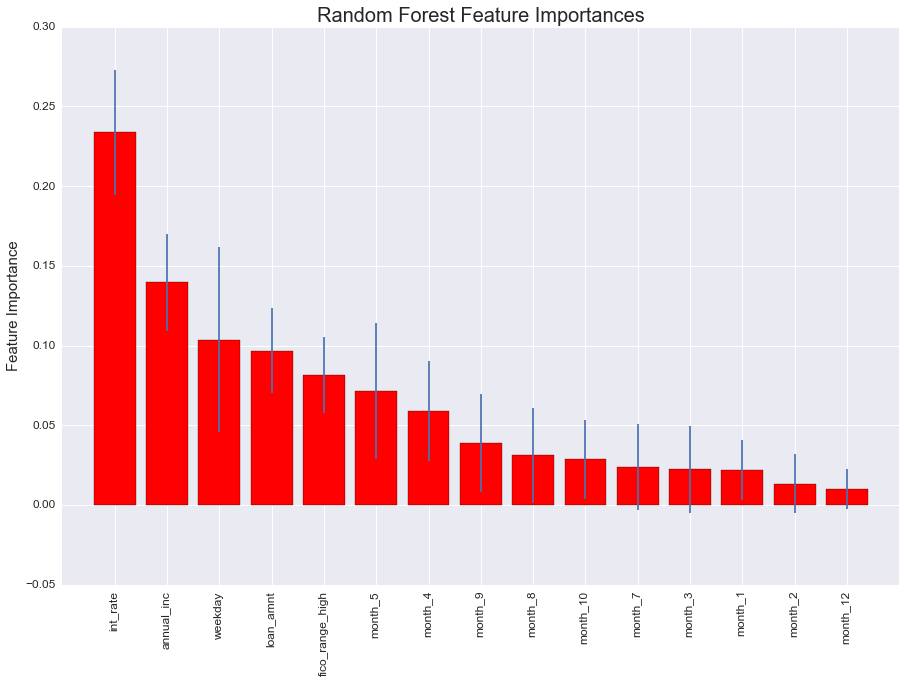

In [235]:
rf = RandomForestClassifier(n_estimators=400, n_jobs=4, min_samples_split=100)
variable_indices = variable_importance(rf, train_x, train_y, fnames=newFeature, TOP_N=15)

In [238]:
params = {'n_estimators':[400],
          'min_samples_split':[1,5,10,20],
          'max_depth':[10,15]}

rf = RandomForestClassifier(n_estimators=400, min_samples_split=100, n_jobs=4)
best_params = optimizer(rf, train_x[variable_indices[:10]], train_y, params, n_jobs=2)

Scoring Function: None
Parameter List: {'n_estimators': [400], 'min_samples_split': [1, 5, 10, 20], 'max_depth': [10, 15]}
Best Parameters: {'min_samples_split': 20, 'n_estimators': 400, 'max_depth': 10}


In [240]:
rf = RandomForestClassifier(n_estimators=400, n_jobs=4, min_samples_split=5)
rf.fit(train_x[variable_indices[:10]], train_y)

prediction =rf.predict_proba(test_x[variable_indices[:10]])

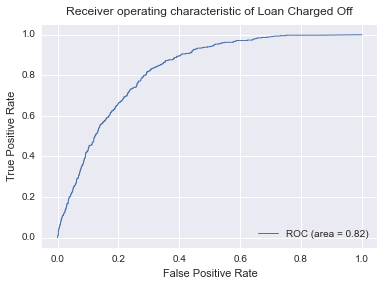

In [241]:
from sklearn.metrics import roc_curve, auc

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)


fpr, tpr, thres = roc_curve(test_y, prediction[:,1])
mean_tpr += np.interp(mean_fpr, fpr, tpr)
mean_tpr[0] = 0.0
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % (roc_auc))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Loan Charged Off', y=1.02)
plt.legend(loc="lower right")
plt.show()

**Model training scenario 2: Split on 2015-08**

In [242]:
from sklearn.cross_validation import train_test_split

splitDate = datetime.datetime(2015,8,1)
train_x, train_y, newFeature = data_preprocessing(training_data[training_data['last_pymnt_d']<splitDate],
                                                  target_col='target', timestamp='last_pymnt_d')

test_x, test_y, _ = data_preprocessing(training_data[training_data['last_pymnt_d']>=splitDate],
                                                target_col='target', timestamp='last_pymnt_d')

train_x.shape, test_x.shape

((11312, 18), (6763, 10))

In [248]:
rf = RandomForestClassifier(n_estimators=400, n_jobs=4, min_samples_split=5)
rf.fit(train_x[variable_indices[:10]], train_y)
        
print 'Check 1: Removing redundant features:'
for name in test_x.columns:
    if name not in newFeature[variable_indices[:10]]:
        test_x.drop(name, axis=1, inplace=True)
        print name

print '\nCheck 2: Adding missing features:'
cnt = 0
for name in newFeature[variable_indices[:10]]:
    if name not in test_x.columns:
        test_x.insert(cnt, name, 0)
        print name
    cnt += 1

prediction = rf.predict_proba(test_x[variable_indices[:10]])

Check 1: Removing redundant features:

Check 2: Adding missing features:


IndexError: indices are out-of-bounds

In [ ]:
from sklearn.metrics import roc_curve, auc

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 500)

fpr, tpr, thres = roc_curve(test_y, prediction[:,1])
mean_tpr += np.interp(mean_fpr, fpr, tpr)
mean_tpr[0] = 0.0
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % (roc_auc))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Loan Charged Off', y=1.02)
plt.legend(loc="lower right")
plt.show()

#### Reset 'Current' loans to the new month, 01/2016:

In [57]:
validation_data = data[data['loan_status']=='Current'].copy()
validation_data['month_since_launch'] = (datetime.datetime(2016,1,1) - validation_data['issue_d']).\
apply(int) / (86400 * 1e9)
validation_data['time_to_fully_paid'] = 365 * 3.0 - validation_data['month_since_launch'] 

In [58]:
validation_data.groupby(['last_pymnt_d', 'loan_status']).agg({'member_id':lambda x:x.nunique(0)})

,,member_id
last_pymnt_d,loan_status,
2015-09-01,Current,391
2015-10-01,Current,219243


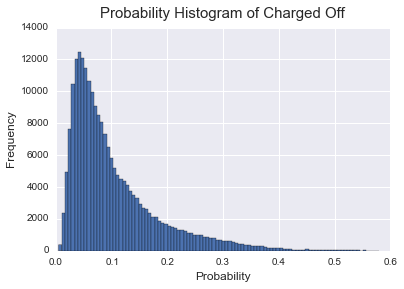

In [59]:
hist = plt.hist(rf.predict_proba(validation_data[Features])[:,1], bins=100)
plt.title('Probability Histogram of Charged Off', y=1.02, fontsize=15)
plt.xlabel('Probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)